In [268]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
from dataclasses import dataclass
from jaxtyping import Float, Int
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from get_books import get_gutenberg_book, get_many_books
from transformers import AutoTokenizer  # for tokenization
from torch.nn import GELU  

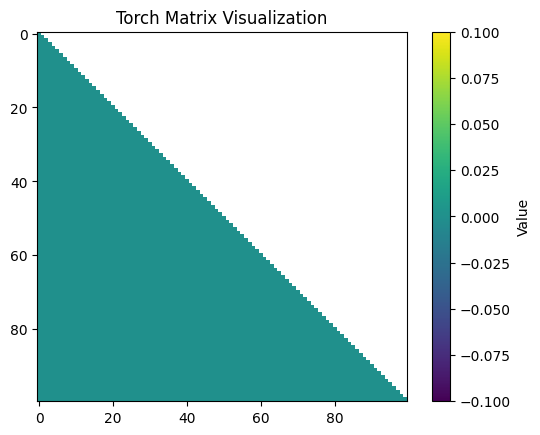

In [269]:
# def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
def create_mask(n_context: int) -> torch.Tensor:
    mask = torch.zeros(n_context, n_context)
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    
    return mask



# Create a random 5x5 matrix
M = create_mask(100)

# Convert to NumPy for visualization
M_np = M.numpy()

# Plot the matrix
plt.imshow(M_np, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Torch Matrix Visualization")
plt.show()

In [270]:
@dataclass
class GPTConfig:
	d_vocab: int = 10_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	max_ctx: int = 512

# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model) # fix this later
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
		

		

	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:

		M = create_mask(x.size(0))
  
		return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
		


class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		#List of attention heads
		self.heads = nn.ModuleList([AttentionHead(cfg) for i in range(cfg.n_heads)])

	#def forward(x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
	def forward(self, x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		
		for head in range(self.cfg.n_heads):
			x = x + self.heads[head].forward(x)
		
		return x
        #Each head returns output of shape [n_context, d_head]
        #Concatenate outputs along the feature dimension: [n_context, n_heads * d_head]
        #Project concatenated outputs back to d_model: [n_context, d_model]




class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.Hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
		self.Output = nn.Linear(cfg.d_mlp, cfg.d_model)
		self.gelu = nn.GELU()
		
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.gelu(self.Output(self.gelu(self.Hidden(x))))



class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg

		self.pos_embedding = nn.Embedding(cfg.max_ctx, cfg.d_model)

		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)
		self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)	

		self.norm1 = nn.LayerNorm(cfg.d_model)
		self.norm2 = nn.LayerNorm(cfg.d_model)

		self.layers = nn.ModuleList(
			nn.ModuleDict({
				'attn': MultiHeadedAttention(cfg),
				'mlp': MLP(cfg)
			}) for _ in range(cfg.n_layers)
		)
  		
		
		# uses `MultiHeadedAttention` and `MLP`
		# uses nn.Embedding for the embedding, transpose of it for the unembedding

	def forward(self, x: Int[torch.Tensor, "n_context d_vocab"]) -> Float[torch.Tensor, "n_context d_vocab"]:
     
		# x is a sequence of token ids, shape (n_context, d_vocab)
		# we need to embed it, then pass it through the transformer layers
		# then we need to unembed it
		# the output of the transformer layers is a sequence of vectors, shape (n_context, d_model)
		# the unembedding layer is a linear layer that maps from d_model to d_vocab
		# the output of the unembedding layer is a sequence of logits, shape (n_context, d_vocab)
		# the logits are the output of the model, we return them
  
		x = self.embedding(x) # shape (n_context, d_model)
		
		positions = torch.arange(0, x.size(0))  # (n_context, 1)
		pos_emb = self.pos_embedding(positions)  # (n_context, d_model)

		x = x + pos_emb

		for layer in self.layers:
			 
			x = x + layer['attn'](self.norm1(x))
			x = x + layer['mlp'](self.norm2(x))
		
		return self.unembedding(x)

In [271]:
cfg = GPTConfig()
#model = Transformer(cfg)
n_context = 10
x = torch.randint(0, cfg.d_vocab, (n_context,))

torch.Size([10])
torch.Size([10, 10000])


C:\Users\shiff\AppData\Local\Temp\ipykernel_17284\2759412671.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


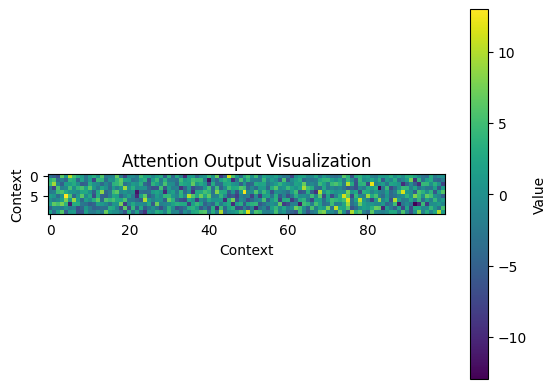

In [272]:
transform = Transformer(cfg)
print(x.shape)
output = transform(x)
print(output.shape)
# print(attn(x))
# print(mh_attn(x))

# visualize the attention scores
plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores

torch.Size([10, 128])
torch.Size([10, 128])


C:\Users\shiff\AppData\Local\Temp\ipykernel_17284\2759412671.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


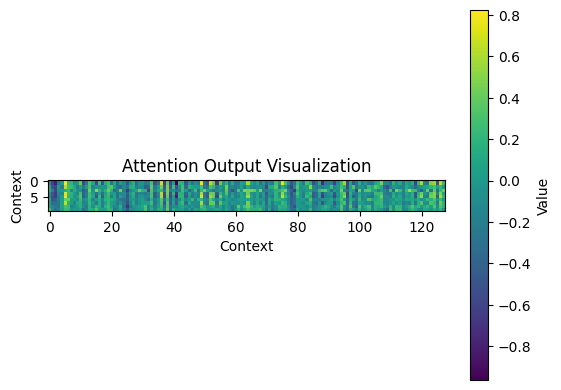

In [273]:
cfg = GPTConfig()

ah = AttentionHead(cfg)
x = torch.randn(10, cfg.d_model)
print(ah(x).shape)

output = ah.forward(x)
print(output.shape)


# visualize the attention scores
plt.imshow(output.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")  # Add a color bar
plt.title("Attention Output Visualization")
plt.xlabel("Context")
plt.ylabel("Context")
plt.show()
# visualize the attention scores


In [274]:
from get_books import get_many_books
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Initialize tokenizer once
model_cfg = GPTConfig(d_model=128, d_vocab=tokenizer.vocab_size, n_heads=4, n_layers=6, d_mlp=512)

book_ids = [8, 15, 51]  
dataset = get_many_books(book_ids, data_temp="./data/gutenberg_data")

rawtext = ""
for book in dataset:
    rawtext += book
tokens = tokenizer(rawtext, return_tensors="pt")

chunk_size = 100
to_remove = tokens["input_ids"].shape[1] % chunk_size
new_shape = tokens["input_ids"].shape[1] // chunk_size

attention_mask = tokens['attention_mask'][0][:-to_remove].reshape(new_shape, chunk_size)
input_ids = tokens['input_ids'][0][:-to_remove].reshape(new_shape, chunk_size)

tensor = TensorDataset(input_ids, attention_mask)

dataloader = DataLoader(tensor, batch_size=8, shuffle=True)

print(input_ids.shape)

Getting book 84...
	4557 characters read
Getting book 84...
	1241025 characters read
Getting book 84...
	434048 characters read


Token indices sequence length is longer than the specified maximum sequence length for this model (484720 > 1024). Running this sequence through the model will result in indexing errors


torch.Size([4847, 100])


In [275]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cpu")
model = Transformer(model_cfg)
model = model.to(device)

# Set up optimizer and loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.train()
n_epochs = 1
print_interval = 10

stop = 0

for epoch in range(n_epochs):
    for step, batch in enumerate(dataloader):
        # [batch_size, seq_len]
        input_ids_batch = batch[0].to(device)

        # We'll accumulate the losses for each sequence in this mini-batch
        total_loss = 0.0
        batch_size = input_ids_batch.size(0)
        
        if stop == 0:

            for i in range(len(input_ids_batch)):

                print(input_ids_batch[i])
                print(tokenizer.decode(input_ids_batch[i]), end='')
                stop = 1

        # Process each sequence individually
        for i in range(batch_size):
            # Extract a single sequence of shape [seq_len]
            seq_ids = input_ids_batch[i]

            # Next-token language modeling: input is all but last token, target is all but first
            inp = seq_ids[:-1]    # shape [seq_len - 1]
            targ = seq_ids[1:]    # shape [seq_len - 1]

            # Forward pass
            # Your model returns logits of shape [seq_len-1, d_vocab]
            logits = model(inp)

            # Compute loss across this sequence
            # CrossEntropyLoss expects [batch, vocab], so we can pass [seq_len-1, d_vocab] vs. [seq_len-1]
            loss = criterion(logits, targ)

            # Accumulate
            total_loss += loss

        # Average across all sequences in the batch
        total_loss = total_loss / batch_size

        # Backprop and update
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress
        if (step + 1) % print_interval == 0:
            print(f"Epoch {epoch+1}, Step {step+1}, Loss: {total_loss.item():.4f}")


tensor([   13, 13786,   502,   616, 35833, 21108,    13,  1148,   616, 30615,
          826,    30,  1703,   314,   845, 14005,    30,   447,   251,   201,
          198,   201,   198,   447,   250,  1639,   804,   655, 14081,    13,
         6031,    11, 40003,    11,  9245,   502,   922,    12, 16390,   329,
          262,   938,   640,    13,   201,   198,    35,  7484, 14488,   481,
         1239,  9245,   502,   757,    13,   447,   251,   201,   198,   201,
          198,   447,   250,    35,  7484, 12206,   481,    11,   996,    13,
         1318,    11,  2802,   447,   247,    82,  4585,    13,  7911,    13,
          447,   251,   201,   198,   201,   198, 14291,   262,  2829,    11,
         1468,    12, 28776,   835,   287,   410,  5119,   788,    11, 15397])
. Give me my bouquet. Is my veil right? Am I very pale?”

“You look just lovely. Di, darling, kiss me good-bye for the last time.
Diana Barry will never kiss me again.”

“Diana Wright will, though. There, mother’s calli

C:\Users\shiff\AppData\Local\Temp\ipykernel_17284\2759412671.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))


Epoch 1, Step 10, Loss: 13.7867
Epoch 1, Step 20, Loss: 11.8880
Epoch 1, Step 30, Loss: 8.7511
Epoch 1, Step 40, Loss: 8.4209
Epoch 1, Step 50, Loss: 7.0346
Epoch 1, Step 60, Loss: 6.9552
Epoch 1, Step 70, Loss: 7.3183
Epoch 1, Step 80, Loss: 7.3647
Epoch 1, Step 90, Loss: 7.0613
Epoch 1, Step 100, Loss: 6.9050
Epoch 1, Step 110, Loss: 7.1132
Epoch 1, Step 120, Loss: 6.4677
Epoch 1, Step 130, Loss: 6.8529
Epoch 1, Step 140, Loss: 7.0186
Epoch 1, Step 150, Loss: 6.6832
Epoch 1, Step 160, Loss: 6.2636
Epoch 1, Step 170, Loss: 6.8172
Epoch 1, Step 180, Loss: 6.0069
Epoch 1, Step 190, Loss: 6.1828
Epoch 1, Step 200, Loss: 6.4731
Epoch 1, Step 210, Loss: 6.4130
Epoch 1, Step 220, Loss: 6.5461
Epoch 1, Step 230, Loss: 5.9495
Epoch 1, Step 240, Loss: 6.3379
Epoch 1, Step 250, Loss: 5.9646
Epoch 1, Step 260, Loss: 6.0291
Epoch 1, Step 270, Loss: 5.8947
Epoch 1, Step 280, Loss: 6.2835
Epoch 1, Step 290, Loss: 5.9460
Epoch 1, Step 300, Loss: 5.7295
Epoch 1, Step 310, Loss: 5.9520
Epoch 1, Step 3

In [277]:

model.eval()

output_tokens = 15

test = "What the hell is wrong with you?"

for new_token in range(output_tokens):
    test_tokens = tokenizer(test, return_tensors="pt")

    with torch.no_grad():
        output = F.softmax(model(test_tokens['input_ids'][0]))

    


    samples = torch.multinomial(output, 1)


   
    detokenized_text = tokenizer.decode(samples[-1][0], skip_special_tokens=True)
        
    
    print(detokenized_text,end='')

    test += detokenized_text


    










C:\Users\shiff\AppData\Local\Temp\ipykernel_17284\2759412671.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.W_Q(x) @ self.W_K(x).T + M) @ self.W_O(self.W_V(x))
C:\Users\shiff\AppData\Local\Temp\ipykernel_17284\980818853.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(model(test_tokens['input_ids'][0]))


� the monster,
main a vicinity to
Gab CHAPTER